<a href="https://colab.research.google.com/github/yexf308/AppliedStatistics/blob/main/Ensemble_Methods_Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

$\def\m#1{\mathbf{#1}}$
$\def\mm#1{\boldsymbol{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
$\def\mr#1{\mathrm{#1}}$
$\newenvironment{rmat}{\left[\begin{array}{rrrrrrrrrrrrr}}{\end{array}\right]}$
$\newcommand\brm{\begin{rmat}}$
$\newcommand\erm{\end{rmat}}$
$\newenvironment{cmat}{\left[\begin{array}{ccccccccc}}{\end{array}\right]}$
$\newcommand\bcm{\begin{cmat}}$
$\newcommand\ecm{\end{cmat}}$



AdaBoost works well, but the lack of explanation for why the algorithm is successful sewed the seeds of doubt. Some considered it a super-algorithm, a silver bullet, but others were skeptical and believed AdaBoost was just overfitting.

The overfitting problem did indeed exist, especially when data had strong outliers. Therefore, in those types of problems, AdaBoost was unstable. 


# Problem setup revisited

We are going to solve the problem of function approximation in a general supervised learning setting. We have a set of features $ \m{x} $ and target variables $y, \left\{ (\m{x}^{(i)}, y^{(i)}) \right\}_{i=1, \ldots,n}$ which we use to restore the dependence $ y = f(\m x) $. We restore the dependence by approximating $ \hat{f}(\m x) $ and by understanding which approximation is better when we use the loss function $ L(y,f) $, which we want to minimize: $  y \approx \hat{f}(\m x),  \hat{f}(\m x) = \underset{f(\m x)}{\arg\min} \ L(y,f(\m x)) $.  

At this moment, we do not make any assumptions regarding the type of dependence $ f(\m x) $, the model of our approximation $  \hat{f}(\m x) $, or the distribution of the target variable $ y $. We only expect the function $ L(y,f) $ to be differentiable. Our approach is very general: we define $ \hat {f}(\m x) $ by minimizing the loss:  
$$\hat{f}(\m x) = \underset{f(\m x)}{\arg\min} \ \mathbb {E} _{\m x,y}[L(y,f(\m x))]  $$

Unfortunately, the number of functions $ f(\m x) $ is not just large, but its functional space is infinite-dimensional. That is why it is acceptable for us to limit the search space by some family of functions $ f(\m x, \theta), \theta \in \mathbb{R}^d $. This simplifies the objective a lot because now we have a solvable optimization of parameter values:
$ \hat{f}(\m x) = f(\m x, \hat{\theta}),$
$$\hat{\theta} = \underset{\theta}{\arg\min} \ \mathbb {E} _{\m x,y}[L(y,f(\m x,\theta))] $$

# Gradient Boosting 
Gradient Boosting  algorithms like AdaBoost and is also a Boosting algorithm.  Boosted Tree are also constructed based on the following two points:

- Training Method: Forward Stepwise Algorithm. The current tree is adjusted and trained based on the results of the previous trees, to improve accuracy.  Boosted Tree Model, which can be represented as follows:


$$
f_M(\m x)=\sum_{i=1}^M \rho_i T(\m x,\theta_i)
$$  

Here, $T(\m x,\theta_i)$ represents a decision tree, $\theta_i$ is the parameter of the decision tree, and $M$ is the number of trees.

The forward Stepwise algorithm for training can be described as follows:

-  Assume the initial Tree is $f_0(\m x)=\lambda$.

-  For $i=1,2,...,M$:
   - $$f_i(\m x)=f_{i-1}(\m x)+\rho_iT(\m x,\theta_i) $$  
   Here, $f_{i-1}(\m x)$ represents the model that has been trained in the previous round. The current round's training objective is to obtain the optimal parameters of the current decision tree by minimizing a certain loss function

   - $$\hat\theta_i, \hat\rho_i=\arg\min_{\theta_i, \rho_i} L(y,f_{i-1}(\m x)+\rho_iT(\m x,\theta_i))$$  

- The final boosted tree becomes $f_M(x)=\sum_{i=1}^M \rho_i T(x,\hat \theta_i) $. 


In terms of the process, we can see the biggest difference between Boosted Trees and AdaBoost:

- AdaBoost focuses on misclassified points, and the next round's objective is more inclined to correct the misclassified points.

- Boosted Trees focus on the difference between the current model and the target. The training objective of the next round's model is to reduce the difference between the model and the target.


the biggest difference in Boosted Trees for different problems lies in the loss function. Next, we will briefly introduce regression Boosted trees with squared loss and classification Boosted trees with exponential loss:






# Boosted Regression Tree

Knowing the expression of loss function's gradient, we can calculate its value on our data. So, let's train the models such that our predictions will be more correlated with this gradient (with a minus sign). In other words, we will use least squares to correct the predictions with these residuals. For classification, regression, and ranking tasks, we will minimize the squared difference between residuals  and our predictions.

If we choose square loss, then

$$
L(y,f(\m x))=\frac{1}{2}(y-f(\m x))^2
$$  

At $i$-step, the loss function is  

$$
L(y,f_{i}(\m x))=\frac{1}{2}[y-f_{i-1}(\m x)-\rho_i T(\m x,\theta_i)]^2
$$  
As both $y$ and $f_{i-1}(\m x)$ are known, the optimal parameter $\theta_i$ that it becomes the following optimization: 
$$
\hat \theta_i = \arg\min_{\theta_i} \sum_{n=1}^N (T(\m x^{(n)},\theta_i)- (y^{(n)}-f_{i-1}(\m x^{(n)})))^2
$$  
Therefore, for the training of step $i$, we only need to use the residual $y-f_{i-1}(\m x)$ as the target $y$ for the model $T(\m x,\theta_i)$.

Then we will need to select an optimal coefficient $\rho_i \in \mathbb{R}$ via binary search or another line search algorithm. 

$$ 
\hat\rho_i=\arg\min_{ \rho_i} L(y,f_{i-1}(\m x)+\rho_iT(\m x,\hat \theta_i))
$$


If we have a more general loss function? For example, if the loss function of a regression tree is absolute value, i.e., $L(y,f(\m x))=\mid y-f(\m x)\mid$, how should we update it? Obviously, the update target is no longer the residual. In fact, the solution is already in use, which is the negative gradient of the loss function with respect to the model:

$$
-\frac{\partial L(y,f(\m x))}{\partial f(\m x)}
$$   
This special case mentioned above is  essentially using the gradient descent method:


$$
-\frac{\partial\frac{1}{2}(y-f(\m x))^2}{\partial f(\m x)}=y-f(\m x)
$$  

Here are four possible choices of losses. 

- Square loss: $L(y,f(\m x))=\frac{1}{2}(f(\m x)-y)^2$ and its negative gradient is $y-f(\m x)$.

- Absolute loss: $L(y,f(\m x))=\mid f(\m x)-y \mid$ and its negative gradient is $\text{sign}(y-f(\m x))$.

- Huber loss: 
$L(y,f(\m x))=\left\{\begin{matrix}
\frac{1}{2}(f(\m x)-y)^2 & \mid y-f(\m x) \mid < \delta\\
\delta \mid y-f(\m x) \mid & \text{otherwise}
\end{matrix}\right.$
and its negative gradient is 
$\left\{\begin{matrix}
y-f(\m x) & \mid y-f(\m x) \mid < \delta\\
\delta\cdot \text{sign}(y-f(\m x)) & \text{otherwise}
\end{matrix}\right.$

- Quantile Loss: $L(y,f(\m x))= \left\{\begin{matrix}
\theta\mid y-f(\m x)\mid &  y>f(\m x)\\
(1-\theta)\mid y-f(\m x)\mid  & \text{otherwise}
\end{matrix}\right.$
and its negative gradient is 
$\left\{\begin{matrix}
\theta &  y>f(\m x)\\
\theta-1  & \text{otherwise}
\end{matrix}\right.$ where $0<\theta< 1$.


## Pro and Con of loss functions
- The squared error amplifies errors that are larger than 1, making it more sensitive to outliers.

- The absolute error can avoid this problem, but it may cross the minimum point due to a large gradient near the minimum point.

- Huber loss and quantile loss mainly avoid the influence of outliers.


## Friedman's classic GBM algorithm

We can now define the classic GBM algorithm suggested by Jerome Friedman in 1999. It is a supervised algorithm that has the following components:

- Training dataset $\left\{ (\m x^{(n)}, y^{(n)}) \right\}_{n=1}^N$;
- Number of iterations $ M$;
- Choice of loss function $ L(y, f)$ with a defined gradient;
- Choice of function family of base estimators $T(\m x, \theta)$ with the training procedure;
- Additional hyperparameters $T(\m x, \theta)$ (for example, in decision trees, the tree depth);

The only thing left is the initial approximation $f_0(x)$. For simplicity, for an initial approximation, a constant value $ \gamma$ is used.

1. Initialize GBM with constant value $f(x) = f_0, f_0 = \gamma,  \gamma \in \mathbb{R}$
$f_0 = \underset{\gamma}{\arg\min} \ \sum_{n = 1}^{N} L(y^{(n)}, \gamma)$

2. For each iteration $i= 1, \dots, M$, repeat:
   -  Calculate pseudo-residuals $\m r_i$,
$ r_{ni} = -\left[\frac{\partial L(y^{(n)}, f(\m x^{(n)}))}{\partial f(\m x^{(n)})}\right]_{f(\m x)=\hat{f}(\m x)}, \quad \mbox{for } n=1,\ldots,N$

   - Build new base estimators $ T(\m x, \theta_i)$ as regression on pseudo-residuals $ \left\{ (\m x^{(n)}, r_{ni}) \right\}_{n=1, \ldots,N}$
   -  Find optimal coefficient $ \rho_i $ at $ T(\m x, \theta_i)$ regarding initial loss function
$\rho_i = \underset{\rho}{\arg\min} \ \sum_{n = 1}^{N} L(y^{(n)}, f(\m x^{(n)}) +  \rho \cdot T(\m x^{(n)}, \theta_i))$
   -  Update current approximation 
$f_i(\m x) = f_{i-1}(\m x) + \rho_i T(\m x, \theta_i) $

3. Compose final GBM model 
$ f_M(\m x) $

<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/translate0.png?raw=true" width="800" />

In [2]:

class GBDTRegressor:

    def __init__(self, max_depth=4, n_estimator=1000, lr=0.2):
        self.max_depth = max_depth
        self.n_estimator = n_estimator
        self.lr = lr
        self.booster = []

        self.best_round = None

    def record_score(self, y_train, y_val, train_predict, val_predict, i):
        mse_val = mean_squared_error(y_val, val_predict)
        if (i+1)%10==0:
            mse_train = mean_squared_error(y_train, train_predict)
            print("At %d\t round training： %.4f\t"
                "validation： %.4f"%(i+1, mse_train, mse_val))
        return mse_val

    def fit(self, X, y):
        # split train and validation
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.25, random_state=0)
        train_predict, val_predict = 0, 0
        next_fit_val = np.full(X_train.shape[0], np.mean(y_train))
        # early_stop to prevent overfitting
        last_val_score = np.infty
        for i in range(self.n_estimator):
            cur_booster = DT(max_depth=self.max_depth)
            cur_booster.fit(X_train, next_fit_val)
            train_predict += cur_booster.predict(X_train) * self.lr
            val_predict += cur_booster.predict(X_val) * self.lr

            next_fit_val = y_train - train_predict
            self.booster.append(cur_booster)
            cur_val_score = self.record_score(
                y_train, y_val, train_predict, val_predict, i)
            if cur_val_score > last_val_score:
                self.best_round = i
                print("\n training stop！The best round is %d"%(i+1))
                break
            last_val_score = cur_val_score

    def predict(self, X):
        cur_predict = 0
        #
        for i in range(self.best_round):
            cur_predict += self.lr * self.booster[i].predict(X)
        return cur_predict

# Test Case 1

In [3]:
data = np.linspace(1, 10, num=100)
target1 = 3*data[:50] + np.random.random(size=50)*3# add noise
target2 = 3*data[50:] + np.random.random(size=50)*10# add noise 
target=np.concatenate([target1,target2])
data = data.reshape((-1, 1))

At 10	 round training： 8.1100	validation： 13.6161

 training stop！The best round is 17


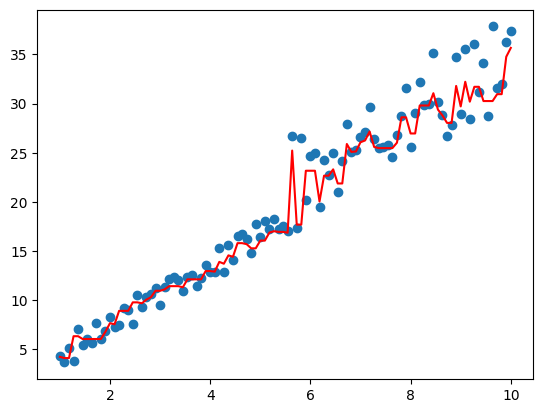

In [4]:
model=GBDTRegressor()
model.fit(data,target)
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')
plt.show()

In [5]:
X, y = make_regression(
        n_samples=10000, n_features=50, n_informative=20, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=0)

model = GBDTRegressor()
model.fit(X_train, y_train)
prediction = model.predict(X_test)
mse = mean_squared_error(y_test, prediction)

At 10	 round training： 25237.9124	validation： 28866.8144
At 20	 round training： 12885.2350	validation： 17349.8984
At 30	 round training： 7479.4206	validation： 11923.1328
At 40	 round training： 4780.9394	validation： 9117.6771
At 50	 round training： 3263.5360	validation： 7376.6959
At 60	 round training： 2388.5911	validation： 6287.8988
At 70	 round training： 1848.7410	validation： 5519.7598
At 80	 round training： 1503.6798	validation： 4994.3938
At 90	 round training： 1284.3260	validation： 4641.5369
At 100	 round training： 1131.2921	validation： 4395.1575
At 110	 round training： 1000.1657	validation： 4167.5632
At 120	 round training： 908.9093	validation： 4024.5044
At 130	 round training： 839.9113	validation： 3897.3988
At 140	 round training： 777.1760	validation： 3810.1868

 training stop！The best round is 145


In [6]:
print("\n MSE of test set is %.4f"%(mse))


 MSE of test set is 4274.3858


# Boosted Classification Tree
Classification can also be done using regression trees. In simple terms, several sets of regression trees, equal to the number of categories, are trained. Each set represents a category, and the outputs of all sets are transformed into a probability distribution using a softmax operation. Then, the negative gradient of each tree is calculated using a loss function such as cross-entropy or KL divergence, and used to guide the next round of training. For example, in a three-category classification, the process is as follows:

<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/translate.png?raw=true" width="800" />

## Softmax + CrossEntropy and their gradient
For classification problems, cross-entropy is generally chosen as the loss function. Note $y$ is the one-hot expression of the label, so $\sum_{i=1}^n y_i=1$.

\begin{align}
&\text{softmax}([\hat{y}_1,\hat{y}_2,...,\hat{y}_n])=\frac{1}{\sum_{i=1}^n e^{\hat y_i}}[e^{\hat y_1},e^{\hat y_2},...,e^{\hat y_n}] \\
& \text{cross entropy}(y,p)=-\sum_{i=1}^n y_i\log p_i
\end{align}
Then the loss function is 
\begin{align}
L(\hat y,y)=-\sum_{i=1}^n y_i\log \frac{e^{\hat y_i}}{\sum_{j=1}^n e^{\hat y_j}}\\
=-\sum_{i=1}^n y_i(\hat y_i-\log\sum_{j=1}^n e^{\hat y_j})\\
=\log\sum_{i=1}^n e^{\hat y_i}-\sum_{i=1}^ny_i\hat y_i
\end{align}

To calculate the gradient: 
\begin{align}
\frac{\partial L(\hat y,y)}{\partial \hat y}=\text{softmax}([\hat y_1,\hat y_2,...,\hat y_n])-[y_1,y_2,...,y_n]
\end{align}

Then the fitting targets of the first set of regression trees are  $y_1-\frac{e^{\hat y_1}}{\sum_{i=1}^n e^{\hat y_i}}$, 
the fitting targets of the second set of regression trees are $y_2-\frac{e^{\hat y_2}}{\sum_{i=1}^n e^{\hat y_i}}$, ..., and the fitting targets of the $n$th set of regression trees are $y_n-\frac{e^{\hat y_n}}{\sum_{i=1}^n e^{\hat y_i}}$

In [7]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score

In [8]:
def one_hot(y):
    res = np.zeros((y.size, y.max()+1))
    res[np.arange(y.size), y] = 1
    return res

class GBDTMultiClassifier:

    def __init__(self, max_depth=4, n_estimator=1000, lr=0.2):
        self.max_depth = max_depth
        self.n_estimator = n_estimator
        self.lr = lr
        self.booster = []

        self.n_classes = None
        self.best_round = None

    def get_init_val(self, y):
        init_val = []
        for c in range(self.n_classes):
            init_val.append(np.log((y[:, c]==1).mean()))
        return np.full((y.shape[0], self.n_classes), init_val)

    def record_score(self, y_train, y_val, train_predict, val_predict, i):
        train_predict = np.exp(train_predict) / np.exp(
            train_predict).sum(1).reshape(-1, 1)
        val_predict = np.exp(val_predict) / np.exp(
            val_predict).sum(1).reshape(-1, 1)
        auc_val = roc_auc_score(y_val, val_predict)
        if (i+1)%10==0:
            auc_train = roc_auc_score(y_train, train_predict)
            print("At %d\t round training： %.4f\t"
                "validation： %.4f"%(i+1, auc_train, auc_val))
        return auc_val

    def fit(self, X, y):
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.25, random_state=0)
        self.n_classes = y.shape[1]
        train_predict = np.zeros((X_train.shape[0], self.n_classes))
        val_predict = np.zeros((X_val.shape[0], self.n_classes))
        next_fit_val = self.get_init_val(y_train)
        last_val_score = - np.infty
        for i in range(self.n_estimator):
            last_train = train_predict.copy()
            self.booster.append([])
            for m in range(self.n_classes):
                cur_booster = DT(max_depth=self.max_depth)
                cur_booster.fit(X_train, next_fit_val[:, m])
                train_predict[:, m] += cur_booster.predict(X_train) * self.lr
                val_predict[:, m] += cur_booster.predict(X_val) * self.lr
                next_fit_val[:, m] = y_train[:, m] - np.exp(
                    last_train[:, m]) / np.exp(last_train).sum(1)
                self.booster[-1].append(cur_booster)
            cur_val_score = self.record_score(
                y_train, y_val, train_predict, val_predict, i)
            if cur_val_score < last_val_score:
                self.best_round = i
                print("\n training stop！The best round is %d"%(i+1))
                break
            last_val_score = cur_val_score

    def predict(self, X):
        cur_predict = np.zeros((X.shape[0], self.n_classes))
        for i in range(self.best_round):
            for m in range(self.n_classes):
                cur_predict[:, m] += self.lr * self.booster[i][m].predict(X)
        return np.exp(cur_predict) / np.exp(cur_predict).sum(1).reshape(-1, 1)

In [16]:
def plot_decision_function(X, y, clf, support_vectors=None):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')
   
    if support_vectors is not None:
        plt.scatter(X[support_vectors, 0], X[support_vectors, 1], s=80, c='none', alpha=0.7, edgecolor='red')



In [24]:
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=.5,random_state=21)


 training stop！The best round is 4


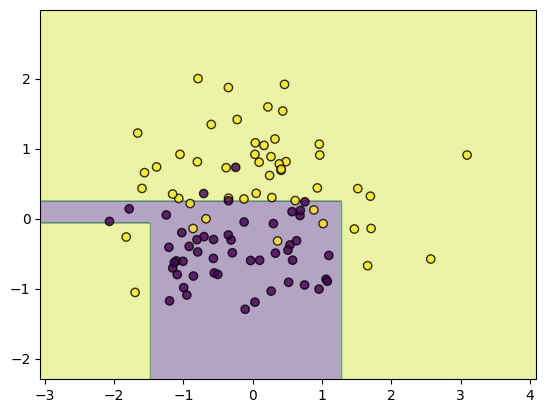

In [25]:
classifier = GBDTMultiClassifier()
target_onehot = one_hot(target)
classifier.fit(data, target_onehot)
plot_decision_function(data, target, classifier)

In [26]:
X, y = make_classification(
        n_samples=10000, n_features=50, n_informative=20,
        n_classes=3, random_state=1)
y = one_hot(y)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=0)

model = GBDTMultiClassifier()
model.fit(X_train, y_train)
prediction = model.predict(X_test)
auc = roc_auc_score(y_test, prediction)
print("\n AUC of test set is %.4f"%(auc))

At 10	 round training： 0.9117	validation： 0.8777
At 20	 round training： 0.9354	validation： 0.9013
At 30	 round training： 0.9499	validation： 0.9147
At 40	 round training： 0.9600	validation： 0.9242
At 50	 round training： 0.9664	validation： 0.9302
At 60	 round training： 0.9718	validation： 0.9359
At 70	 round training： 0.9759	validation： 0.9402
At 80	 round training： 0.9789	validation： 0.9426
At 90	 round training： 0.9816	validation： 0.9451
At 100	 round training： 0.9839	validation： 0.9471
At 110	 round training： 0.9859	validation： 0.9493
At 120	 round training： 0.9873	validation： 0.9504
At 130	 round training： 0.9889	validation： 0.9518
At 140	 round training： 0.9902	validation： 0.9531
At 150	 round training： 0.9914	validation： 0.9540

 training stop！The best round is 154

 AUC of test set is 0.9514


$\def\m#1{\mathbf{#1}}$
$\def\mm#1{\boldsymbol{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
$\def\mr#1{\mathrm{#1}}$
$\newenvironment{rmat}{\left[\begin{array}{rrrrrrrrrrrrr}}{\end{array}\right]}$
$\newcommand\brm{\begin{rmat}}$
$\newcommand\erm{\end{rmat}}$
$\newenvironment{cmat}{\left[\begin{array}{ccccccccc}}{\end{array}\right]}$
$\newcommand\bcm{\begin{cmat}}$
$\newcommand\ecm{\end{cmat}}$